In [52]:
import pandas as pd
from datetime import datetime
import marko
from marko.block import Heading
from marko.inline import RawText
from typing import Union, List

def extract_text(node) -> str:
    """
    Recursively extracts plain text from a marko node (including inline formatting).
    """
    if isinstance(node, RawText):
        return node.children
    if hasattr(node, 'children'):
        return ''.join(extract_text(child) for child in node.children)
    return ''

def parse_markdown(filepath: str, skip_first_heading: bool = False, column_map: dict = None) -> pd.DataFrame:
    """
    Parses a Markdown travel log file using marko to extract travel durations grouped by country and city.
    Splits visits to the same location into multiple entries if they appear non-consecutively.

    Parameters:
        filepath (str): Path to the .md file.
        skip_first_heading (bool): Whether to skip the first heading (e.g., title or introduction).
        column_map (dict): Optional mapping of output column names, e.g., {'country': 'Country', 'city': 'City', ...}

    Returns:
        pd.DataFrame: A DataFrame with columns [Country, City, Start, End, Duration] by default.
    """
    with open(filepath, encoding="utf-8") as f:
        content = f.read()

    ast = marko.parse(content)

    country = city = None
    date_entries = []
    heading_count = 0

    for node in ast.children:
        if not isinstance(node, Heading):
            continue

        heading_count += 1
        if skip_first_heading and heading_count == 1:
            continue

        level = node.level
        text = extract_text(node).strip()

        if level == 1:
            country = text
            city = None  # reset city
        elif level == 2:
            city = text
        elif level == 3:
            parts = text.split(", ")
            if len(parts) == 2:
                try:
                    date = datetime.strptime(parts[1], "%d.%m.%Y").date()
                    effective_city = city if city else country
                    date_entries.append({
                        "country": country,
                        "city": effective_city,
                        "date": date
                    })
                except ValueError:
                    continue  # malformed date

    # Sentry date entry

    # Sort by date to ensure order
    date_entries.sort(key=lambda x: x["date"])

    # Track city/country transitions
    visits = []
    if not date_entries:
        return pd.DataFrame(columns=column_map.values() if column_map else [])

    prev = date_entries[0]
    start_date = end_date = prev["date"]

    for i in range(1, len(date_entries)):
        entry = date_entries[i]
        is_last = i == len(date_entries) - 1

        if entry["country"] == prev["country"] and entry["city"] == prev["city"] and not is_last:
            end_date = entry["date"]  # extend visit
        else:
            visits.append({
                "country": prev["country"],
                "city": prev["city"],
                "start": start_date,
                "end": end_date,
                "duration": (end_date - start_date).days + 1
            })
            prev = entry
            start_date = end_date = entry["date"]

    # Default column mapping
    default_columns = {
        "country": "Country",
        "city": "City",
        "start": "Start",
        "end": "End",
        "duration": "Duration"
    }

    if column_map:
        columns = column_map
    else:
        columns = default_columns

    # Build DataFrame using column map
    df = pd.DataFrame([
        {
            columns["country"]: visit["country"],
            columns["city"]: visit["city"],
            columns["start"]: visit["start"],
            columns["end"]: visit["end"],
            columns["duration"]: visit["duration"]
        }
        for visit in visits
    ])

    return df

def summarize_travel(df: pd.DataFrame, column_map: dict = None, show_total: bool = True) -> pd.DataFrame:
    """
    Summarizes travel statistics per country:
    - Total duration (sum of days)
    - Number of unique cities visited
    - First date of entry
    - Last date of exit
    - (Optional) Total row with overall stats

    Parameters:
        df (pd.DataFrame): The travel DataFrame returned by parse_markdown.
        column_map (dict): Optional mapping of DataFrame column names.
        show_total (bool): Whether to include a final row with totals.

    Returns:
        pd.DataFrame: Summary table with optional total row.
    """
    default_columns = {
        "country": "Country",
        "city": "City",
        "duration": "Duration",
        "start": "Start",
        "end": "End"
    }

    columns = column_map if column_map else default_columns

    summary = df.groupby(columns["country"]).agg(
        Total_Days=(columns["duration"], "sum"),
        Cities_Visited=(columns["city"], pd.Series.nunique),
        Entry_Date=(columns["start"], "min"),
        Exit_Date=(columns["end"], "max")
    ).reset_index()

    # Sort by Entry_Date
    summary = summary.sort_values(by="Entry_Date").reset_index(drop=True)

    if show_total:
        total_row = {
            columns["country"]: "TOTAL",
            "Total_Days": summary["Total_Days"].sum(),
            "Cities_Visited": summary["Cities_Visited"].sum(),
            "Entry_Date": summary["Entry_Date"].min(),
            "Exit_Date": summary["Exit_Date"].max()
        }
        summary = pd.concat([summary, pd.DataFrame([total_row])], ignore_index=True)

    return summary

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
import time

def map_cities_to_coords(df: pd.DataFrame, city_col="City", country_col="Country", user_agent="city-geocoder") -> pd.DataFrame:
    """
    Adds 'Latitude' and 'Longitude' columns to the DataFrame by geocoding city and country.
    If a city cannot be geocoded, sets both to None.

    Parameters:
        df (pd.DataFrame): Input DataFrame with city and country columns.
        city_col (str): Name of the column containing city names.
        country_col (str): Name of the column containing country names.
        user_agent (str): Identifier for the Nominatim geocoder.

    Returns:
        pd.DataFrame: DataFrame with additional 'Latitude' and 'Longitude' columns.
    """
    geolocator = Nominatim(user_agent=user_agent)
    latitudes, longitudes = [], []

    for _, row in df.iterrows():
        location_str = f"{row[city_col]}, {row[country_col]}"
        try:
            location = geolocator.geocode(location_str, timeout=10)
            if location:
                latitudes.append(location.latitude)
                longitudes.append(location.longitude)
            else:
                latitudes.append(None)
                longitudes.append(None)
        except (GeocoderTimedOut, GeocoderUnavailable):
            latitudes.append(None)
            longitudes.append(None)
        time.sleep(0.25)  # Be polite to the API

    df["Latitude"] = latitudes
    df["Longitude"] = longitudes
    return df

def get_unmapped_locations(df: pd.DataFrame, lat_col="Latitude", lon_col="Longitude") -> pd.DataFrame:
    """
    Returns a DataFrame of all entries where latitude or longitude is None.

    Parameters:
        df (pd.DataFrame): The DataFrame with geolocation columns.
        lat_col (str): Name of the latitude column.
        lon_col (str): Name of the longitude column.

    Returns:
        pd.DataFrame: Rows where coordinates are missing.
    """
    return df[df[lat_col].isna() | df[lon_col].isna()]

from typing import Union, List

def set_manual_coordinates_by_index(
    df: pd.DataFrame,
    updates: Union[List[Union[int, float]], List[List[Union[int, float]]]],
    lat_col: str = "Latitude",
    lon_col: str = "Longitude"
) -> pd.DataFrame:
    """
    Manually sets latitude and longitude for rows identified by their index.

    Parameters:
        df (pd.DataFrame): DataFrame to update.
        updates (list): Either a single update [index, lat, lon] or a list of such updates.
        lat_col (str): Name of the latitude column.
        lon_col (str): Name of the longitude column.

    Returns:
        pd.DataFrame: Updated DataFrame with manual coordinates set.
    """
    if isinstance(updates[0], (int, float)):
        updates = [updates]  # single update case

    for idx, lat, lon in updates:
        if idx in df.index:
            df.at[idx, lat_col] = lat
            df.at[idx, lon_col] = lon

    return df

In [40]:
df = parse_markdown("reise.md", skip_first_heading=True)
df

,Country,City,Start,End,Duration
0,Singapur,Singapur,2024-08-08,2024-08-13,6
1,Indonesien,Malang,2024-08-14,2024-08-16,3
2,Indonesien,Yogyakarta,2024-08-19,2024-08-24,6
3,Indonesien,Bandung,2024-08-25,2024-08-27,3
4,Indonesien,Jakarta,2024-08-28,2024-08-28,1
5,Japan,Tokio,2024-08-29,2024-09-08,11
6,Japan,Fuji,2024-09-09,2024-09-13,5
7,Japan,Takayama,2024-09-14,2024-09-18,5
8,Japan,Kanazawa,2024-09-19,2024-09-20,2
9,Japan,Tottori,2024-09-21,2024-09-22,2


In [41]:
df_summary=summarize_travel(df)
df_summary

,Country,Total_Days,Cities_Visited,Entry_Date,Exit_Date
0,Singapur,6,1,2024-08-08,2024-08-13
1,Indonesien,13,4,2024-08-14,2024-08-28
2,Japan,77,19,2024-08-29,2024-11-13
3,Korea,24,5,2024-11-14,2024-12-07
4,Taiwan,27,7,2024-12-08,2025-01-03
5,Thailand,15,3,2025-01-06,2025-02-13
6,Laos,23,4,2025-01-21,2025-02-12
7,TOTAL,185,43,2024-08-08,2025-02-13


In [42]:
df_geo=map_cities_to_coords(df, city_col="City", country_col="Country")
df_geo

,Country,City,Start,End,Duration,Latitude,Longitude
0,Singapur,Singapur,2024-08-08,2024-08-13,6,1.289918,103.851907
1,Indonesien,Malang,2024-08-14,2024-08-16,3,-7.977131,112.634027
2,Indonesien,Yogyakarta,2024-08-19,2024-08-24,6,-7.801265,110.364686
3,Indonesien,Bandung,2024-08-25,2024-08-27,3,-6.921553,107.611021
4,Indonesien,Jakarta,2024-08-28,2024-08-28,1,-6.175405,106.827168
5,Japan,Tokio,2024-08-29,2024-09-08,11,35.676860,139.763895
6,Japan,Fuji,2024-09-09,2024-09-13,5,35.362799,138.730781
7,Japan,Takayama,2024-09-14,2024-09-18,5,36.139625,137.251032
8,Japan,Kanazawa,2024-09-19,2024-09-20,2,36.561627,136.656882
9,Japan,Tottori,2024-09-21,2024-09-22,2,35.355508,133.867852


In [55]:
unmapped=get_unmapped_locations(df_geo)
unmapped

,Country,City,Start,End,Duration,Latitude,Longitude


In [54]:
updates=[10,34.816667, 134.683333 ]
df_geo=set_manual_coordinates_by_index(df_geo,updates)

In [56]:
df_geo

,Country,City,Start,End,Duration,Latitude,Longitude
0,Singapur,Singapur,2024-08-08,2024-08-13,6,1.289918,103.851907
1,Indonesien,Malang,2024-08-14,2024-08-16,3,-7.977131,112.634027
2,Indonesien,Yogyakarta,2024-08-19,2024-08-24,6,-7.801265,110.364686
3,Indonesien,Bandung,2024-08-25,2024-08-27,3,-6.921553,107.611021
4,Indonesien,Jakarta,2024-08-28,2024-08-28,1,-6.175405,106.827168
5,Japan,Tokio,2024-08-29,2024-09-08,11,35.676860,139.763895
6,Japan,Fuji,2024-09-09,2024-09-13,5,35.362799,138.730781
7,Japan,Takayama,2024-09-14,2024-09-18,5,36.139625,137.251032
8,Japan,Kanazawa,2024-09-19,2024-09-20,2,36.561627,136.656882
9,Japan,Tottori,2024-09-21,2024-09-22,2,35.355508,133.867852


In [68]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Optional, Dict

def plot_travel_map(
    df: pd.DataFrame,
    lat_col: str = "Latitude",
    lon_col: str = "Longitude",
    city_col: str = "City",
    duration_col: str = "Duration",
    date_col: str = "Start",
    default_marker_size: int = 5,
    marker_scale: float = 2.0,
    color_scale: str = "Viridis",
    line_opacity: float = 0.6,
    plot_kwargs: Optional[Dict] = None
) -> go.Figure:
    """
    Plots a world map of visited cities with size based on duration and color based on entry date.

    Parameters:
        df (pd.DataFrame): DataFrame with geolocation and visit data.
        lat_col (str): Name of the latitude column.
        lon_col (str): Name of the longitude column.
        city_col (str): Name of the city column.
        duration_col (str): Name of the duration column.
        date_col (str): Name of the date column (should be datetime).
        default_marker_size (int): Minimum size for markers.
        marker_scale (float): Scaling factor for marker size.
        color_scale (str): Color scale name for Plotly.
        line_opacity (float): Opacity of the lines connecting cities.
        plot_kwargs (dict): Additional keyword arguments to pass to `go.Figure`.

    Returns:
        go.Figure: The resulting Plotly figure.
    """
    if plot_kwargs is None:
        plot_kwargs = {}

    df_sorted = df.sort_values(by=date_col).reset_index(drop=True)

    # Normalize date to float for coloring
    date_min = df_sorted[date_col].min()
    date_max = df_sorted[date_col].max()
    date_range = (df_sorted[date_col] - date_min) / (date_max - date_min + pd.Timedelta(days=1e-9))

    # Compute marker size and color
    sizes = df_sorted[duration_col].fillna(1) * marker_scale + default_marker_size
    colors = date_range

    # Create scatter trace for cities
    scatter = go.Scattergeo(
        lat=df_sorted[lat_col],
        lon=df_sorted[lon_col],
        text=[f"{row[city_col]}<br>{row[date_col].strftime('%d.%m.%Y')} - {(row[date_col]+timedelta(days=row[duration_col])).strftime('%d.%m.%Y')}:  {row[duration_col]} days" for _, row in df_sorted.iterrows()],
        mode="markers",
        marker=dict(
            size=sizes,
            color=colors,
            colorscale=color_scale,
            colorbar=dict(title="Date"),
            opacity=0.8,
            line=dict(width=0.5, color="black")
        ),
        name="Cities"
    )

    # Create line segments
    lines = []
    for i in range(len(df_sorted) - 1):
        lat0, lon0 = df_sorted.loc[i, [lat_col, lon_col]]
        lat1, lon1 = df_sorted.loc[i + 1, [lat_col, lon_col]]
        color0 = colors[i]
        color1 = colors[i + 1]
        # Midpoint color for the line
        mid_color = 0.5 * (color0 + color1)

        lines.append(go.Scattergeo(
            lat=[lat0, lat1],
            lon=[lon0, lon1],
            mode="lines",
            line=dict(width=2, color=f"rgba(0, 0, 0, {line_opacity})"),  # neutral fade
            opacity=line_opacity,
            showlegend=False
        ))

    if auto_center:
            lat_min, lat_max = df_sorted[lat_col].min(), df_sorted[lat_col].max()
            lon_min, lon_max = df_sorted[lon_col].min(), df_sorted[lon_col].max()
            lat_center = (lat_min + lat_max) / 2
            lon_center = (lon_min + lon_max) / 2
            lat_range = lat_max - lat_min
            lon_range = lon_max - lon_min

            geo_scope.update(
                center=dict(lat=lat_center, lon=lon_center),
                lataxis=dict(range=[lat_min - lat_range * 0.2, lat_max + lat_range * 0.2]),
                lonaxis=dict(range=[lon_min - lon_range * 0.2, lon_max + lon_range * 0.2])
            )

    fig = go.Figure([scatter] + lines, **plot_kwargs)

    fig.update_layout(
        geo=dict(
            projection_type="natural earth",
            showland=True,
            landcolor="rgb(243, 243, 243)",
            showcountries=True,
            countrycolor="rgb(204, 204, 204)",
        ),
        title="Travel Map",
        margin=dict(l=0, r=0, t=40, b=0)
    )

    return fig


In [91]:
import plotly.graph_objects as go
from plotly.colors import sample_colorscale
import pandas as pd
import numpy as np
from typing import Optional, Dict

import plotly.colors as pc

def get_rgb_from_scale(value: float, colorscale: str) -> tuple:
    """
    Convert a normalized value (0-1) into an RGB tuple using the given Plotly colorscale.

    Parameters:
        value (float): Normalized value between 0 and 1.
        colorscale (str): Name of the Plotly color scale.

    Returns:
        tuple: (r, g, b)
    """
    # Ensure value is in [0, 1]
    value = max(0, min(1, value))
    rgb_string = pc.find_intermediate_color(
        pc.get_colorscale(colorscale)[0][1],
        pc.get_colorscale(colorscale)[-1][1],
        value,
        colortype="rgb"
    )
    return tuple(int(x) for x in rgb_string.strip("rgb()").split(","))


def plot_travel_map(
    df: pd.DataFrame,
    lat_col: str = "Latitude",
    lon_col: str = "Longitude",
    city_col: str = "City",
    duration_col: str = "Duration",
    date_col: str = "Start",
    default_marker_size: int = 5,
    marker_scale: float = 2.0,
    color_scale: str = "Viridis",
    line_opacity: float = 0.6,
    auto_center: bool = False,
    plot_kwargs: Optional[Dict] = None
) -> go.Figure:
    """
    Plots a world map of visited cities with size based on duration and color based on entry date.

    Parameters:
        df (pd.DataFrame): DataFrame with geolocation and visit data.
        lat_col (str): Name of the latitude column.
        lon_col (str): Name of the longitude column.
        city_col (str): Name of the city column.
        duration_col (str): Name of the duration column.
        date_col (str): Name of the entry date column (should be datetime).
        default_marker_size (int): Minimum size for markers.
        marker_scale (float): Scaling factor for marker size.
        color_scale (str): Color scale name for Plotly.
        line_opacity (float): Opacity of the lines connecting cities.
        auto_center (bool): If True, zoom to the bounding box of the cities.
        plot_kwargs (dict): Additional keyword arguments to pass to `go.Figure`.

    Returns:
        go.Figure: The resulting Plotly figure.
    """
    if plot_kwargs is None:
        plot_kwargs = {}

    df_sorted = df.sort_values(by=date_col).reset_index(drop=True)

    # Normalize date to float for coloring
    date_min = df_sorted[date_col].min()
    date_max = df_sorted[date_col].max()
    date_range = (df_sorted[date_col] - date_min) / (date_max - date_min + pd.Timedelta(days=1e-9))

    # Compute marker size and color
    sizes = df_sorted[duration_col].fillna(1) * marker_scale + default_marker_size

    # Create scatter trace for cities
    scatter = go.Scattergeo(
        lat=df_sorted[lat_col],
        lon=df_sorted[lon_col],
        text=[f"{row[city_col]}<br>{row[date_col].strftime('%d.%m.%Y')} - {(row[date_col]+timedelta(days=row[duration_col])).strftime('%d.%m.%Y')}:  {row[duration_col]} days" for _, row in df_sorted.iterrows()],
        mode="markers",
        marker=dict(
            size=sizes,
            color=date_range,
            colorscale=color_scale,
            colorbar=dict(title="Date"),
            opacity=0.8,
            line=dict(width=0.5, color="black")
        ),
        name="Cities"
    )

    # Create line segments between cities
    lines = []
    # Loop through cities and create colored lines
    for i in range(len(df_sorted) - 1):
        lat0, lon0 = df_sorted.loc[i, [lat_col, lon_col]]
        lat1, lon1 = df_sorted.loc[i + 1, [lat_col, lon_col]]

        # Normalized color values
        norm0 = date_range.iloc[i]
        norm1 = date_range.iloc[i + 1]

        # Sample colors from scale
        rgb0 = sample_colorscale(color_scale, norm0, colortype='rgb')[0]
        rgb1 = sample_colorscale(color_scale, norm1, colortype='rgb')[0]

        # Convert to RGB tuple and compute midpoint
        def rgb_str_to_tuple(rgb_str):
            return tuple(int(v.strip()) for v in rgb_str.strip("rgb() ").split(","))

        rgb0_tuple = rgb_str_to_tuple(rgb0)
        rgb1_tuple = rgb_str_to_tuple(rgb1)

        mid_rgb = tuple((a + b) // 2 for a, b in zip(rgb0_tuple, rgb1_tuple))
        rgba_color = f"rgba({mid_rgb[0]}, {mid_rgb[1]}, {mid_rgb[2]}, {line_opacity})"

        lines.append(go.Scattergeo(
            lat=[lat0, lat1],
            lon=[lon0, lon1],
            mode="lines",
            line=dict(width=2, color=rgba_color),
            opacity=line_opacity,
            showlegend=False
        ))

    # Calculate bounds if auto_center is enabled
    geo_scope = dict(
        projection_type="natural earth",
        resolution=50,
        showland=True,
        landcolor="rgb(243, 243, 243)",
        showcountries=True,
        countrycolor="rgb(204, 204, 204)",
    )

    if auto_center:
        lat_min, lat_max = df_sorted[lat_col].min(), df_sorted[lat_col].max()
        lon_min, lon_max = df_sorted[lon_col].min(), df_sorted[lon_col].max()
        lat_center = (lat_min + lat_max) / 2
        lon_center = (lon_min + lon_max) / 2
        lat_range = lat_max - lat_min
        lon_range = lon_max - lon_min

        geo_scope.update(
            center=dict(lat=lat_center, lon=lon_center),
            #lataxis=dict(range=[lat_min - lat_range * 0.2, lat_max + lat_range * 0.2]),
            #lonaxis=dict(range=[lon_min - lon_range * 0.2, lon_max + lon_range * 0.2])
        )

    fig = go.Figure([scatter] + lines, **plot_kwargs)

    fig.update_layout(
        geo=geo_scope,
        title="Travel Map",
        margin=dict(l=0, r=0, t=40, b=0)
    )

    return fig


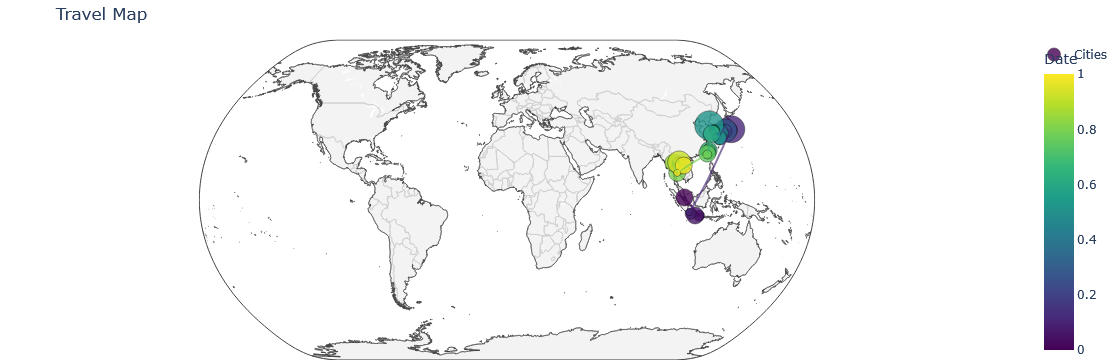

In [92]:
fig = plot_travel_map(df_geo, auto_center=False, line_opacity=0.8)
fig.show()
